In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import models, transforms, datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

# Paths and data transformations
data_dir = "/kaggle/input/microscopic-peripheral-blood-cell-images/PBC_dataset_normal_DIB"
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:

# Load dataset
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
indices = list(range(len(full_dataset)))

# Load MobileNetV2 model for feature extraction
model = models.mobilenet_v2(pretrained=True)
model.classifier = nn.Identity()  # Remove classifier to use as feature extractor
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Feature extraction function
def extract_features(loader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

# Classifiers and accuracies dictionary
classifiers = {
    "MobileNetV2_KNN": KNeighborsClassifier(n_neighbors=3),
    "MobileNetV2_SVM": SVC(kernel='linear'),
    "MobileNetV2_RF": RandomForestClassifier(n_estimators=100)
}
accuracies = {name: {"train": [], "test": []} for name in classifiers.keys()}

# Data splits
dataper = [0.01, 0.05, 0.1, 0.2, 0.3]
for i in dataper:
    # Split data
    train_idx, test_idx = train_test_split(indices, train_size=i, random_state=42)
    val_idx, test_idx = train_test_split(test_idx, test_size=0.8, random_state=42)

    train_dataset = Subset(full_dataset, train_idx)
    test_dataset = Subset(full_dataset, test_idx)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print(f"Train set: {len(train_dataset)} images")
    print(f"Test set: {len(test_dataset)} images")

    # Extract features
    train_features, train_labels = extract_features(train_loader)
    test_features, test_labels = extract_features(test_loader)

    # Normalize features
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    test_features = scaler.transform(test_features)

    # Train and evaluate classifiers
    for name, clf in classifiers.items():
        # Cross-validation on training data
        scores = cross_val_score(clf, train_features, train_labels, cv=5, scoring='accuracy')
        train_acc = np.mean(scores)
        accuracies[name]["train"].append(round(train_acc * 100, 2))

        # Train on full training set
        clf.fit(train_features, train_labels)

        # Test accuracy
        test_preds = clf.predict(test_features)
        test_acc = accuracy_score(test_labels, test_preds)
        accuracies[name]["test"].append(round(test_acc * 100, 2))

        print(f'{name} -> Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')




/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 143MB/s]


Train set: 170 images
Test set: 13538 images
MobileNetV2_KNN -> Train Acc: 0.4176, Test Acc: 0.3961
MobileNetV2_SVM -> Train Acc: 0.6176, Test Acc: 0.6186
MobileNetV2_RF -> Train Acc: 0.5000, Test Acc: 0.5049
Train set: 854 images
Test set: 12991 images
MobileNetV2_KNN -> Train Acc: 0.5281, Test Acc: 0.5215
MobileNetV2_SVM -> Train Acc: 0.7751, Test Acc: 0.7824
MobileNetV2_RF -> Train Acc: 0.6311, Test Acc: 0.6284
Train set: 1709 images
Test set: 12307 images
MobileNetV2_KNN -> Train Acc: 0.5799, Test Acc: 0.5767
MobileNetV2_SVM -> Train Acc: 0.8122, Test Acc: 0.8235
MobileNetV2_RF -> Train Acc: 0.6676, Test Acc: 0.6777
Train set: 3418 images
Test set: 10940 images
MobileNetV2_KNN -> Train Acc: 0.6179, Test Acc: 0.6250
MobileNetV2_SVM -> Train Acc: 0.8400, Test Acc: 0.8479
MobileNetV2_RF -> Train Acc: 0.6943, Test Acc: 0.7077
Train set: 5127 images
Test set: 9572 images
MobileNetV2_KNN -> Train Acc: 0.6411, Test Acc: 0.6475
MobileNetV2_SVM -> Train Acc: 0.8467, Test Acc: 0.8476
MobileN

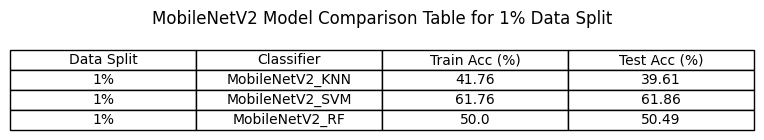

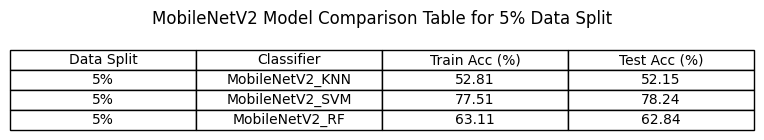

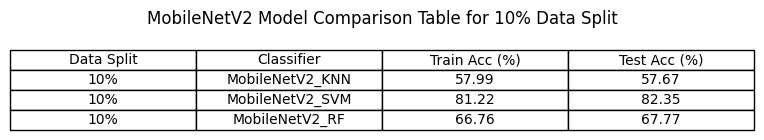

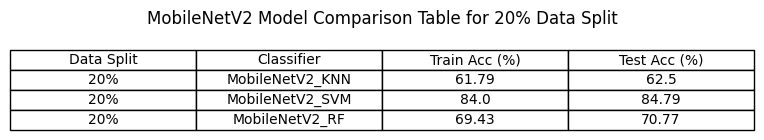

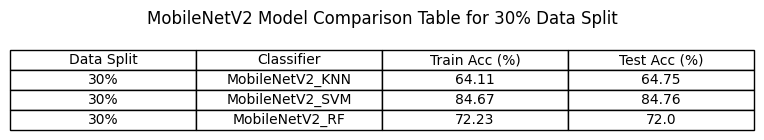

In [4]:
# Visualization of results
for i, p in enumerate(dataper):
    data = {
        'Data Split': [f'{int(p * 100)}%', f'{int(p * 100)}%', f'{int(p * 100)}%'],
        'Classifier': ['MobileNetV2_KNN', 'MobileNetV2_SVM', 'MobileNetV2_RF'],
        'Train Acc (%)': [accuracies['MobileNetV2_KNN']['train'][i],
                          accuracies['MobileNetV2_SVM']['train'][i],
                          accuracies['MobileNetV2_RF']['train'][i]],
        'Test Acc (%)': [accuracies['MobileNetV2_KNN']['test'][i],
                         accuracies['MobileNetV2_SVM']['test'][i],
                         accuracies['MobileNetV2_RF']['test'][i]]
    }
    df = pd.DataFrame(data)
    fig, ax = plt.subplots(figsize=(8, 1))
    ax.axis('tight')
    ax.axis('off')
    tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1.2, 1.2)
    plt.title(f'MobileNetV2 Model Comparison Table for {int(p * 100)}% Data Split', pad=20)
    plt.show()